# 使用感知器识别手写数字的例子——MNIST

In [1]:
import pylab
import numpy as np
import pickle
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import os
import gzip

In [2]:
np.random.seed(1)
import random

## 加载数据

In [3]:
# 解压并加载数据集
with gzip.open('../data/mnist.pkl.gz', 'rb') as mnist_pickle:
    u = pickle._Unpickler(mnist_pickle)
    u.encoding = 'latin1'
    MNIST = u.load()

In [4]:
# minst训练数据
print(MNIST)
# 第一个训练数据的灰度图 28 * 28 像素
print(MNIST['Train']['Features'][0])
# 前十个训练数据的label
print(MNIST['Train']['Labels'][0:10])
# 所有灰度数据归一化
features = MNIST['Train']['Features'].astype(np.float32) / 256.0
# 所有的label
labels = MNIST['Train']['Labels']

{'Train': {'Labels': array([1, 0, 1, ..., 7, 6, 9]), 'Features': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])}}
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0 188 255  94   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 191 250 253
  93   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

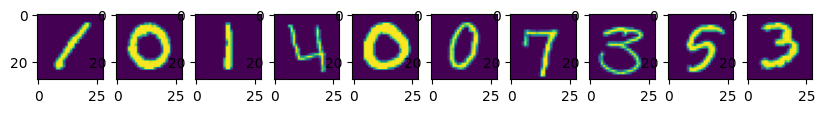

In [5]:
# 使用 pylab 绘制前十个数据的图像
fig = pylab.figure(figsize=(10,5))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    pylab.imshow(features[i].reshape(28,28))
pylab.show()

因为感知器是二元分类器，所以只能用来区分两个数据，这里用来区分0和1

In [6]:
# 将数据集中的两个数据设置为 pos 和 neg
def set_mnist_pos_neg(positive_label, negative_label):
    # pos 和 neg 数据的序号
    positive_indices = [i for i, j in enumerate(MNIST['Train']['Labels']) 
                          if j == positive_label]
    negative_indices = [i for i, j in enumerate(MNIST['Train']['Labels']) 
                          if j == negative_label]
    # pos 和 neg 数据的图像
    positive_images = MNIST['Train']['Features'][positive_indices]
    negative_images = MNIST['Train']['Features'][negative_indices]

    # 输出一个 pos 数据和一个 neg 数据，让我们看的更清楚
    fig = pylab.figure()
    ax = fig.add_subplot(1, 2, 1)
    pylab.imshow(positive_images[0].reshape(28,28), cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 2, 2)
    pylab.imshow(negative_images[0].reshape(28,28), cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    pylab.show()
    
    return positive_images, negative_images

## 识别 1 和 0

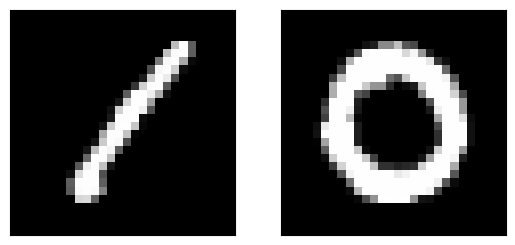

In [7]:
# 数据设置为 1 和 0
pos1, neg1 = set_mnist_pos_neg(1,0)

In [8]:
# 训练方法
def train_graph(positive_examples, negative_examples, num_iterations = 100):
    # 数据维度, 此例是 28 * 28 = 784
    num_dims = positive_examples.shape[1]
    # 权重值 全0数组 shape = (784, 1)
    weights = np.zeros((num_dims,1)) # initialize weights

    # pos 和 neg 的数量
    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]

    # 报告频次
    report_frequency = 2;
    snapshots = []
    correct = []
    
    for i in range(num_iterations):
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)   
        if z < 0:
            weights = weights + pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0:
            weights = weights - neg.reshape(weights.shape)
            
        if i % report_frequency == 0:             
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)        
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            # 权重快照和正确率
            snapshots.append(np.copy(weights))
            correct.append((pos_correct+neg_correct)/2.0)

    return np.array(snapshots), np.array(correct)

In [9]:
# 绘制结果图像
def plotit2(_snapshots, _correct, step):
    fig = pylab.figure(figsize=(10,4))
    ax = fig.add_subplot(1, 2, 1)
    # 绘制权重值
    pylab.imshow(_snapshots[step].reshape(28, 28), interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    pylab.colorbar()
    # 绘制正确率曲线和当前步骤标识
    ax = fig.add_subplot(1, 2, 2)
    ax.set_ylim([0,1])
    pylab.plot(np.arange(len(_correct)), _correct)
    pylab.plot(step, _correct[step], "bo")
    pylab.show()

def pl3(step):
    plotit2(snapshots_mn, correct_mn, step)

def pl4(step):
    plotit2(snapshots_mn2, correct_mn2, step)  

In [10]:
snapshots_mn, correct_mn = train_graph(pos1, neg1, 1000)
interact(pl3, step=widgets.IntSlider(value=0, min=0, max=len(snapshots_mn) - 1))

interactive(children=(IntSlider(value=0, description='step', max=499), Output()), _dom_classes=('widget-intera…

<function __main__.pl3(step)>

## 识别 2 和 5

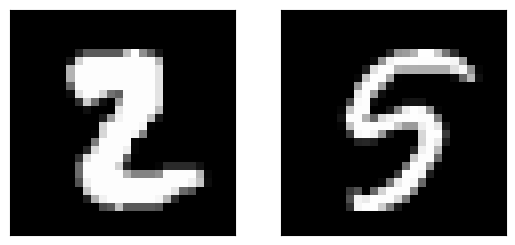

In [11]:
pos2, neg2 = set_mnist_pos_neg(2, 5)

In [12]:
snapshots_mn2, correct_mn2 = train_graph(pos2, neg2, 1000)
interact(pl4, step=widgets.IntSlider(value=0, min=0, max=len(snapshots_mn2) - 1))

interactive(children=(IntSlider(value=0, description='step', max=499), Output()), _dom_classes=('widget-intera…

<function __main__.pl4(step)>

可以看到正确率相对于 1 和 0 的组合，降低了一些

## 使用 PCA 降低特征维度 查看学习结果差异的成因

In [14]:
from sklearn.decomposition import PCA

def pca_analysis(positive_label, negative_label):
    positive_images, negative_images = set_mnist_pos_neg(positive_label, negative_label)
    M = np.append(positive_images, negative_images, 0)

    mypca = PCA(n_components=2)
    mypca.fit(M)

    # 各取 200 个数据 变成 二维数据
    pos_points = mypca.transform(positive_images[:200])
    neg_points = mypca.transform(negative_images[:200])

    # 绘制
    pylab.plot(pos_points[:,0], pos_points[:,1], 'bo')
    pylab.plot(neg_points[:,0], neg_points[:,1], 'ro')

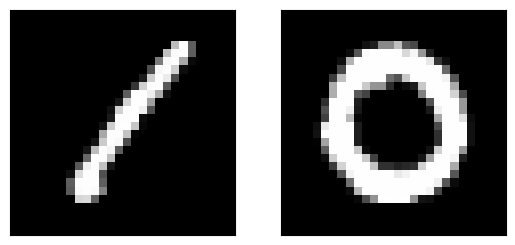

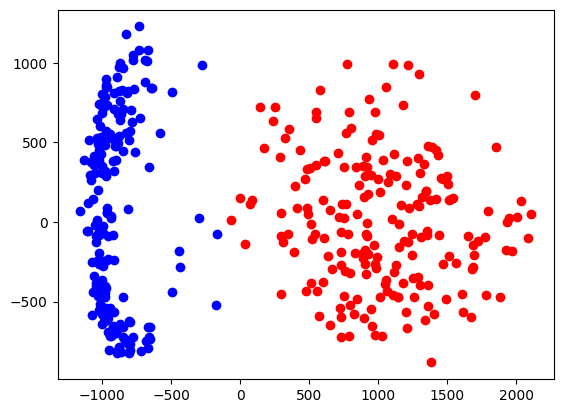

In [15]:
pca_analysis(1,0)

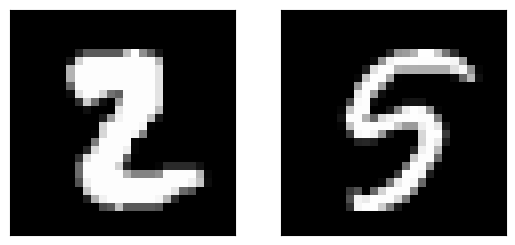

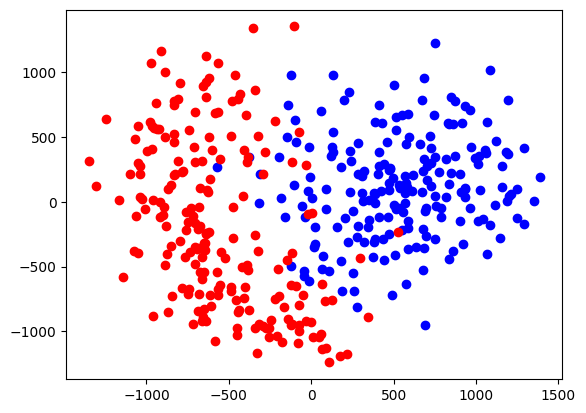

In [16]:
pca_analysis(2,5)

可以看到 0 和 1 是明显的线性可分的，而 2 和 5 有一部分混杂在一起。